# COVID-19 air pollution project. 
## Finding D value
### Written by Bujin Bekbulat

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statistics as stats
import scipy.stats as st
import scipy.io as sio
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import seaborn as sns
import statsmodels.stats.multicomp as multi
import matplotlib.dates as md
import datetime
from math import sqrt
import plotly.graph_objects as go
%matplotlib inline
from scipy.stats import iqr
from statistics import median 
from math import sin, cos, sqrt, atan2, radians
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)


In [ ]:
#Reading file with all the states name
states = pd.read_csv("/Users/Bujin/Downloads/States.csv")

#Reading dates
dateparse = lambda dates: [pd.datetime.strptime(d, '%Y-%m-%d') for d in dates]


#Defining output
DF=pd.DataFrame()
Slope=pd.DataFrame()
OT=pd.DataFrame()
adjusted=[]
idw=[]
total_mon=0
DF5=pd.DataFrame()
Slope5=pd.DataFrame()
OT5=pd.DataFrame()
adjusted5=[]
idw5=[]
lastday=2
twoweeks=16
length=125
totallength=191



#Calling each state file

Data = pd.read_csv("/Users/Bujin/Downloads/NO2.csv",parse_dates=['Date'], date_parser=dateparse)
    
a=[x for x in  list(set(Data['ID'])) if pd.notnull(x)] #each unique monitors in each state
total_mon=total_mon+len(a) #Counting total monitors

    #Defining output
df=pd.DataFrame()
slope1=pd.DataFrame()
ot=pd.DataFrame()
df5=pd.DataFrame()
slope15=pd.DataFrame()
ot5=pd.DataFrame()
whole=Data[Data['Date']<pd.to_datetime('2020-09-'+str(lastday))] 
print(len(whole))   
    #for each station calculate D value   
for iii in range(0,len(a)):
       monitor=Data[Data['ID']==a[iii]]
       
       
       #Defining as variables
       #site=list(monitor['Site'])[0]     
       state=list(monitor['State'])[0] 
       idd=list(monitor['ID'])[0]
       county=list(monitor['County'])[0]
       lon=(list(monitor['Longitude'])[0])
       lat=(list(monitor['Latitude'])[0])
       weeknum=0
    
       #Defining output
       List10=[] 
       slope=[]  
       List5=[] 
       slope5=[]  

   
       #Starting filters
       
       #Days pre and post covid

       whole=monitor[monitor['Date']<pd.to_datetime('2020-09-'+str(lastday))] ##Change this date (add 7 days each week)
       twentytwenty=pd.concat([whole['Date'],whole['2020']],axis=1,sort=False)
       twentytwenty=twentytwenty.dropna()
       pre=twentytwenty[twentytwenty['Date']<pd.to_datetime('2020-03-19')]
       post=twentytwenty[twentytwenty['Date']>=pd.to_datetime('2020-03-19')]
       print(len(whole))
       #Number of days for adjusting
       adjusting=monitor[monitor['Date']<pd.to_datetime('2020-09-'+str(twoweeks))] ## Change this date (add 7 days each week)

       #dropping years if it has incomplete data
       drop=adjusting.drop(['2020'],axis=1)
       drop=drop.dropna(thresh=0.75*len(adjusting), axis=1)
       
       #checking if it has 2 years out of last 3 years
       Iqr=pd.concat([adjusting['2019'],adjusting['2018'],adjusting['2017']],axis=1,sort=False)
       Iqr = Iqr.dropna(thresh=0.75*len(Iqr), axis=1)
       print(whole)
       
       start='2020-01-01'
       
       #Using monitors that have enough data
       if len(drop.columns)>=10 and len(post)>=length  and len(adjusting)>=totallength and len(pre)>=59 and len(Iqr.columns)>=2:   ##Change this (add 5 days on post and adjusting each week)
                                        
        for j in range(0,len(whole),7): # Week by week
            
           #Start and end date for each week
          start_d = pd.to_datetime(start) + datetime.timedelta(j)
          end_d = start_d + datetime.timedelta(7)
         
          week=monitor[monitor['Date']>=start_d]
          week=week[week['Date']<end_d]
          if len(week)>0: 
           #Week 
           twenty=pd.DataFrame(week["2020"])
           weeknum=weeknum+1 #Week #
           
           #Month (for adjusting)
           end_date = list(week['Date'])[0] + datetime.timedelta(days=21) # +2 weeks
           start_date = list(week['Date'])[0] - datetime.timedelta(days=14) # -2 weeks

        
           # First 2 weeks of the year, add december data from previous year
           if pd.to_datetime('2020-01-01')== list(week['Date'])[0] :
               half=monitor[monitor["Date"]>='2020-12-18']
               month=monitor[monitor["Date"]>='2020-01-01']
               month=month[month['Date']<'2020-01-22']
               half.rename(columns={"2020": "2009", "2019": "2020","2018":"2019","2017":"2018","2016":"2017","2015":"2016","2014":"2015","2013":"2014","2012":"2013","2011":"2012","2010":"2011","2009":'2010'}, inplace=True)
               month = pd.concat((month, half), axis=0)
               month=month.drop(['2009'],axis=1)
           elif list(week['Date'])[0]==pd.to_datetime('2020-01-08'):
               half=monitor[monitor["Date"]>'2020-12-24']
               month=monitor[monitor["Date"]>='2020-01-01']
               month=month[month['Date']<'2020-01-29'] 
               half.rename(columns={"2020": "2009", "2019": "2020","2018":"2019","2017":"2018","2016":"2017","2015":"2016","2014":"2015","2013":"2014","2012":"2013","2011":"2012","2010":"2011",'2009':'2010'}, inplace=True)
               month = pd.concat((month, half), axis=0)
               month=month.drop(['2009'],axis=1)
           else:
               month=monitor[monitor["Date"]>=start_date]
               month=month[month["Date"]<end_date]
               month=month.drop(['2009'],axis=1)
        
           #if len(month.columns)==19:
               #month=month.drop(['2009'],axis=1)
           
           Mnth=month.drop(['2020'], axis=1)
           
           #Change the 2020 data to only that particular week
           month["2020"]=twenty
           
           #Dropping columns to get only historical data
           months=month.drop(['2020'],axis=1)
           months=month.drop(['name'],axis=1)
           months=months.drop(['State'],axis=1)
           months=months.drop(['Longitude'],axis=1)          
           months=months.drop(['Latitude'],axis=1)
           months=months.drop(['Date'],axis=1)
           months=months.drop(['ID'],axis=1)
           months=months.drop(['County'],axis=1)
           months=months.drop(['Site'],axis=1)
           months=months.drop(['id'],axis=1)
           Iqr=pd.concat([adjusting['2019'],adjusting['2018'],adjusting['2017']],axis=1,sort=False)
           Iqr = Iqr.dropna(thresh=0.75*len(Iqr), axis=1)
           five=months
           five=five.drop(['2010'],axis=1)
           five=five.drop(['2011'],axis=1)
           five=five.drop(['2012'],axis=1)
           five=five.drop(['2013'],axis=1)
           five=five.drop(['2014'],axis=1)           



           #Filtering data, using years that have enough data
           historical=months.dropna(thresh=0.75*len(months),axis=1)
           #historical=months.dropna(axis=1,how='all')
           histfive=five.dropna(thresh=0.75*len(five),axis=1)
           #Finding median for each year
           medians=np.nanmedian(historical,axis=0)
           fivemed=np.nanmedian(histfive,axis=0)
           #Finding iqr
           IQR_melt = pd.melt(month.reset_index(), id_vars=['index'], value_vars=Iqr.columns)
           IQR_melt=IQR_melt.dropna()
           IQR_melt.columns = ['index', 'year', 'value']
           
           #Finding slope of historical data
           hist_slope=pd.DataFrame({"x":pd.to_numeric(historical.columns),"y":np.array(medians)})
           x=hist_slope["x"]
           y=hist_slope["y"]
           five_slope=pd.DataFrame({"x":pd.to_numeric(histfive.columns),"y":np.array(fivemed)})
           x5=five_slope["x"]
           y5=five_slope["y"]


           #Finding historical median
           
           Historical_melt = pd.melt(month.reset_index(), id_vars=['index'], value_vars=historical.columns)
           Historical_melt.columns = ['index', 'year', 'value']
 
           five_melt = pd.melt(month.reset_index(), id_vars=['index'], value_vars=histfive.columns)
           five_melt.columns = ['index', 'year', 'value']


            # Will get a slope if it has more than 8 years of data
           if len(historical.columns)>=8:
                  
                  #10 year median 
                  Med=np.nanmedian(Historical_melt['value'])  
                
                  #Finding historical slope and r2 value
                  trend, intercept, r_value, p_value, std_err = st.linregress(x,y)
                  
                  #Adjusting historical median
                  adjusted_med =  trend * (len(historical.columns)+1)/2 + Med

                  #Calculating D value 
                  D_value=(np.nanmedian(month['2020'])-adjusted_med)/iqr(IQR_melt['value'])  
                
                  #Appending for output
                  List10.append([D_value,np.nanmedian(month['2020']),Med,adjusted_med,trend,r_value**2,("Week "+str(weeknum)),state,idd,county,lat,lon])
                  
                  #Appending for idw
                  adjusted.append([idd,radians(lat),radians(lon),trend,"Week "+str(weeknum)])
                  slope.append(trend)
                  
                  
           else:

                  idw.append([idd,radians(lat),radians(lon)])
                
           if len(histfive.columns)>=4:
                  
                  #10 year median 
                  Med5=np.nanmedian(five_melt['value'])  
                
                  #Finding historical slope and r2 value
                  trend5, intercept, r_value5, p_value, std_err = st.linregress(x5,y5)
                  
                  #Adjusting historical median
                  adjusted_med5 =  trend5 * (len(histfive.columns)+1)/2 + Med5

                  #Calculating D value 
                  D_value5=(np.nanmedian(month['2020'])-adjusted_med5)/iqr(IQR_melt['value'])  
                
                  #Appending for output
                  List5.append([D_value5,np.nanmedian(month['2020']),Med5,adjusted_med5,trend5,r_value5**2,("Week "+str(weeknum)),state,idd,county,lat,lon])
                  
                  #Appending for idw
                  adjusted5.append([idd,radians(lat),radians(lon),trend5,"Week "+str(weeknum)])
                  slope5.append(trend5)
                  
                  
           else:

                  idw5.append([idd,radians(lat),radians(lon)])

                  
                
        slope=pd.DataFrame(slope)
        slope5=pd.DataFrame(slope5)

        
        #Preparing for idw
        
        if slope.size>0:
           slope.columns=[str(idd)]
        if slope5.size>0:
           slope5.columns=[str(idd)]

         
        #Appending if it has 8 years of data
        if len(historical.columns)>=8:
          ot=pd.concat([ot,monitor],axis=0,sort=False)
        slope1=pd.concat([slope1,slope],axis=1,sort=False)   
        List10=pd.DataFrame(List10)
        df=pd.concat([df, List10], axis=0, sort=False)      
        if len(histfive.columns)>=4:
          ot5=pd.concat([ot5,monitor],axis=0,sort=False)
        slope15=pd.concat([slope15,slope5],axis=1,sort=False)   
        List5=pd.DataFrame(List5)
        df5=pd.concat([df5, List5], axis=0, sort=False)      


    #Concating for output
       
OT=pd.concat([OT,ot],axis=0,sort=False)
DF=pd.concat([DF, df], axis=0, sort=False)
Slope=pd.concat([Slope,slope1],axis=1,sort=False)
OT5=pd.concat([OT5,ot5],axis=0,sort=False)
DF5=pd.concat([DF5, df5], axis=0, sort=False)
Slope5=pd.concat([Slope5,slope15],axis=1,sort=False)

    






/Users/Bujin/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning:

Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.

/Users/Bujin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.



104705
245
            Date  2020  id name  Latitude  Longitude  2019  2014  2015  2016  \
90024 2020-01-01   NaN NaN  NaN    30.462    -91.179  21.3  17.0   6.6  14.2   
90025 2020-01-02   NaN NaN  NaN    30.462    -91.179  12.2  19.2  13.6  14.9   
90026 2020-01-03   NaN NaN  NaN    30.462    -91.179  21.8  34.9  11.8  34.5   
90027 2020-01-04   NaN NaN  NaN    30.462    -91.179  19.3  24.1  15.0  34.0   
90028 2020-01-05   NaN NaN  NaN    30.462    -91.179  38.3  21.0  24.4  25.3   
...          ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
90264 2020-08-28   NaN NaN  NaN    30.462    -91.179  18.2   NaN  32.7   5.2   
90265 2020-08-29   NaN NaN  NaN    30.462    -91.179  16.3   NaN  20.7  19.5   
90266 2020-08-30   NaN NaN  NaN    30.462    -91.179  20.5   NaN  18.3  18.9   
90267 2020-08-31   NaN NaN  NaN    30.462    -91.179  17.5   NaN  27.4   9.0   
90268 2020-09-01   NaN NaN  NaN    30.462    -91.179   6.7   NaN  21.7  32.3   

       ...  2018     Site   

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



245
             Date  2020  id name  Latitude  Longitude  2019  2014  2015  2016  \
121851 2020-01-01   NaN NaN  NaN    32.984    -97.064   5.4  13.5   9.7  10.8   
121852 2020-01-02   NaN NaN  NaN    32.984    -97.064   6.9  20.4   7.5  16.8   
121853 2020-01-03   NaN NaN  NaN    32.984    -97.064   6.3  34.1  10.3  12.0   
121854 2020-01-04   NaN NaN  NaN    32.984    -97.064  20.4   9.7  13.4  34.2   
121855 2020-01-05   NaN NaN  NaN    32.984    -97.064  38.9   2.5  35.6  27.1   
...           ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
122091 2020-08-28   NaN NaN  NaN    32.984    -97.064  13.9  27.6  16.0   5.4   
122092 2020-08-29   NaN NaN  NaN    32.984    -97.064  20.7  13.2   8.6  12.4   
122093 2020-08-30   NaN NaN  NaN    32.984    -97.064  17.8   7.7   8.8  10.6   
122094 2020-08-31   NaN NaN  NaN    32.984    -97.064   7.4   6.0  12.6  11.5   
122095 2020-09-01   NaN NaN  NaN    32.984    -97.064  13.8   4.8  12.7   8.3   

        ...  2018      

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



245
            Date  2020       id                          name  Latitude  \
37191 2020-01-01  20.0  34129.0  Sacramento - T Street AirNow    38.568   
37192 2020-01-02  31.0  34129.0  Sacramento - T Street AirNow    38.568   
37193 2020-01-03  30.0  34129.0  Sacramento - T Street AirNow    38.568   
37194 2020-01-04  28.0  34129.0  Sacramento - T Street AirNow    38.568   
37195 2020-01-05  22.0  34129.0  Sacramento - T Street AirNow    38.568   
...          ...   ...      ...                           ...       ...   
58370 2020-08-28   NaN      NaN                           NaN    38.568   
58371 2020-08-29   NaN      NaN                           NaN    38.568   
58372 2020-08-30   NaN      NaN                           NaN    38.568   
58373 2020-08-31   NaN      NaN                           NaN    38.568   
58374 2020-09-01   NaN      NaN                           NaN    38.568   

       Longitude  2019  2014  2015  2016  ...  2018                      Site  \
37191   -121.4

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



245
            Date  2020  id name  Latitude  Longitude  2019  2014  2015  2016  \
57773 2020-01-01   NaN NaN  NaN    38.683   -121.164   NaN  12.0   NaN  18.0   
57774 2020-01-02   NaN NaN  NaN    38.683   -121.164   NaN   NaN   NaN  16.0   
57775 2020-01-03   NaN NaN  NaN    38.683   -121.164   NaN   NaN   NaN  14.0   
57776 2020-01-04   NaN NaN  NaN    38.683   -121.164   NaN   NaN   NaN  14.0   
57777 2020-01-05   NaN NaN  NaN    38.683   -121.164   NaN   NaN   NaN  12.0   
...          ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
58013 2020-08-28   NaN NaN  NaN    38.683   -121.164   NaN   8.0   9.0   4.0   
58014 2020-08-29   NaN NaN  NaN    38.683   -121.164   NaN   8.0   4.0   4.0   
58015 2020-08-30   NaN NaN  NaN    38.683   -121.164   NaN   4.0   5.0   4.0   
58016 2020-08-31   NaN NaN  NaN    38.683   -121.164   NaN   8.0  10.0   6.0   
58017 2020-09-01   NaN NaN  NaN    38.683   -121.164   NaN  10.0   5.0   5.0   

       ...  2018               Site

             Date  2020       id                          name  Latitude  \
32616  2020-01-01   2.0  22454.0  Laramie County Mobile AirNow    41.085   
32617  2020-01-02   4.0  22454.0  Laramie County Mobile AirNow    41.085   
32618  2020-01-03   5.0  22454.0  Laramie County Mobile AirNow    41.085   
32619  2020-01-04   4.0  22454.0  Laramie County Mobile AirNow    41.085   
32620  2020-01-05   2.0  22454.0  Laramie County Mobile AirNow    41.085   
...           ...   ...      ...                           ...       ...   
153866 2020-08-28   NaN      NaN                           NaN    41.085   
153867 2020-08-29   NaN      NaN                           NaN    41.085   
153868 2020-08-30   NaN      NaN                           NaN    41.085   
153869 2020-08-31   NaN      NaN                           NaN    41.085   
153870 2020-09-01   NaN      NaN                           NaN    41.085   

        Longitude  2019  2014  2015  2016  ...  2018                   Site  \
32616   

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



244
             Date  2020       id          name  Latitude  Longitude  2019  \
41491  2020-01-01   4.0  34232.0  RYDER AirNow    47.941   -101.572   8.7   
41492  2020-01-02   3.0  34232.0  RYDER AirNow    47.941   -101.572   4.4   
41493  2020-01-03   6.0  34232.0  RYDER AirNow    47.941   -101.572   4.0   
41494  2020-01-04   4.0  34232.0  RYDER AirNow    47.941   -101.572   3.6   
41495  2020-01-05   3.0  34232.0  RYDER AirNow    47.941   -101.572   2.9   
...           ...   ...      ...           ...       ...        ...   ...   
41730  2020-08-30   3.0  34232.0  RYDER AirNow    47.941   -101.572   NaN   
41731  2020-08-31   2.0  34232.0  RYDER AirNow    47.941   -101.572   NaN   
41732  2020-09-01   1.0  34232.0  RYDER AirNow    47.941   -101.572   NaN   
111173 2020-05-08   NaN      NaN           NaN    47.941   -101.572   3.3   
111174 2020-05-09   NaN      NaN           NaN    47.941   -101.572   2.3   

        2014  2015  2016  ...  2018   Site         State         ID  Co

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



245
             Date  2020  id name  Latitude  Longitude  2019  2014  2015  2016  \
122583 2020-01-01   NaN NaN  NaN    32.806    -97.357   6.0  17.6  10.1  12.0   
122584 2020-01-02   NaN NaN  NaN    32.806    -97.357  10.0  29.5  12.7  16.2   
122585 2020-01-03   NaN NaN  NaN    32.806    -97.357   9.5  32.5  19.7  14.2   
122586 2020-01-04   NaN NaN  NaN    32.806    -97.357  34.1   9.8  17.3  36.5   
122587 2020-01-05   NaN NaN  NaN    32.806    -97.357  39.1   3.6  35.0  33.6   
...           ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
122823 2020-08-28   NaN NaN  NaN    32.806    -97.357  20.8  33.2  29.7  15.9   
122824 2020-08-29   NaN NaN  NaN    32.806    -97.357  21.7  21.7  18.8  22.5   
122825 2020-08-30   NaN NaN  NaN    32.806    -97.357  19.3  13.8  16.3  23.1   
122826 2020-08-31   NaN NaN  NaN    32.806    -97.357  13.0  10.2  17.3  22.9   
122827 2020-09-01   NaN NaN  NaN    32.806    -97.357  22.9   7.8  16.8  17.0   

        ...  2018      

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



245
             Date  2020  id name  Latitude  Longitude  2019  2014  2015  2016  \
118923 2020-01-01   NaN NaN  NaN    43.746   -101.941   7.0   1.9   2.1   1.7   
118924 2020-01-02   NaN NaN  NaN    43.746   -101.941   1.8   1.6   1.2   1.8   
118925 2020-01-03   NaN NaN  NaN    43.746   -101.941   1.4   1.1   1.3   2.1   
118926 2020-01-04   NaN NaN  NaN    43.746   -101.941   1.7   0.7   0.7   3.1   
118927 2020-01-05   NaN NaN  NaN    43.746   -101.941   0.8   0.6   1.5   3.9   
...           ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
119163 2020-08-28   NaN NaN  NaN    43.746   -101.941   0.3   0.9   1.4   0.0   
119164 2020-08-29   NaN NaN  NaN    43.746   -101.941   0.3   0.8   1.1   0.0   
119165 2020-08-30   NaN NaN  NaN    43.746   -101.941   0.0   1.1   0.7   0.0   
119166 2020-08-31   NaN NaN  NaN    43.746   -101.941   0.8   0.8   1.3   0.0   
119167 2020-09-01   NaN NaN  NaN    43.746   -101.941   0.8   0.6   1.1   0.0   

        ...  2018      

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



245
            Date  2020       id                  name  Latitude  Longitude  \
33634 2020-01-01  20.0  34089.0  Chico -  East AirNow    39.762    -121.84   
33635 2020-01-02  18.0  34089.0  Chico -  East AirNow    39.762    -121.84   
33636 2020-01-03  21.0  34089.0  Chico -  East AirNow    39.762    -121.84   
33637 2020-01-04  18.0  34089.0  Chico -  East AirNow    39.762    -121.84   
33638 2020-01-05  19.0  34089.0  Chico -  East AirNow    39.762    -121.84   
...          ...   ...      ...                   ...       ...        ...   
33874 2020-08-29  11.0  34089.0  Chico -  East AirNow    39.762    -121.84   
33875 2020-08-30   8.0  34089.0  Chico -  East AirNow    39.762    -121.84   
33876 2020-08-31  11.0  34089.0  Chico -  East AirNow    39.762    -121.84   
33877 2020-09-01  16.0  34089.0  Chico -  East AirNow    39.762    -121.84   
70030 2020-07-16   NaN      NaN                   NaN    39.762    -121.84   

       2019  2014  2015  2016  ...  2018               Site

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



245
             Date  2020  id name  Latitude  Longitude  2019  2014  2015  2016  \
100540 2020-01-01   NaN NaN  NaN    48.318   -107.862   1.0   NaN   1.0   1.0   
100541 2020-01-02   NaN NaN  NaN    48.318   -107.862   0.0   NaN   3.0   1.0   
100542 2020-01-03   NaN NaN  NaN    48.318   -107.862   0.0   NaN   1.0   4.0   
100543 2020-01-04   NaN NaN  NaN    48.318   -107.862   0.0   NaN   2.0   5.0   
100544 2020-01-05   NaN NaN  NaN    48.318   -107.862   1.0   NaN   2.0   4.0   
...           ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
100780 2020-08-28   NaN NaN  NaN    48.318   -107.862   1.0   1.0   2.0   1.0   
100781 2020-08-29   NaN NaN  NaN    48.318   -107.862   2.0   1.0   4.0   2.0   
100782 2020-08-30   NaN NaN  NaN    48.318   -107.862   1.0   1.0   2.0   1.0   
100783 2020-08-31   NaN NaN  NaN    48.318   -107.862   2.0   2.0   4.0   2.0   
100784 2020-09-01   NaN NaN  NaN    48.318   -107.862   3.0   2.0   2.0   1.0   

        ...  2018   Sit

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/Bujin/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning:

All-NaN slice encountered



245
            Date  2020      id          name  Latitude  Longitude  2019  2014  \
25189 2020-01-01  15.0  5490.0  Ute 3 AirNow    37.103    -107.87   NaN  19.0   
25190 2020-01-02  16.0  5490.0  Ute 3 AirNow    37.103    -107.87   NaN  20.0   
25191 2020-01-03  16.0  5490.0  Ute 3 AirNow    37.103    -107.87   NaN  11.0   
25192 2020-01-04  17.0  5490.0  Ute 3 AirNow    37.103    -107.87   NaN  13.0   
25193 2020-01-05  12.0  5490.0  Ute 3 AirNow    37.103    -107.87   NaN   5.0   
...          ...   ...     ...           ...       ...        ...   ...   ...   
71656 2020-07-24   NaN     NaN           NaN    37.103    -107.87   NaN   4.0   
71657 2020-07-25   NaN     NaN           NaN    37.103    -107.87   NaN  10.0   
71658 2020-07-26   NaN     NaN           NaN    37.103    -107.87   NaN  13.0   
71659 2020-07-27   NaN     NaN           NaN    37.103    -107.87   NaN  11.0   
71660 2020-08-25   NaN     NaN           NaN    37.103    -107.87   NaN  12.0   

       2015  2016  ... 

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/Bujin/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning:

All-NaN slice encountered



245
            Date  2020      id                          name  Latitude  \
9791  2020-01-01  20.0  3071.0  Eliza Howell- Roadway AirNow    42.386   
9792  2020-01-02  26.0  3071.0  Eliza Howell- Roadway AirNow    42.386   
9793  2020-01-03  23.0  3071.0  Eliza Howell- Roadway AirNow    42.386   
9794  2020-01-04   8.0  3071.0  Eliza Howell- Roadway AirNow    42.386   
9795  2020-01-05  17.0  3071.0  Eliza Howell- Roadway AirNow    42.386   
...          ...   ...     ...                           ...       ...   
10031 2020-08-29  21.0  3071.0  Eliza Howell- Roadway AirNow    42.386   
10032 2020-08-30  19.0  3071.0  Eliza Howell- Roadway AirNow    42.386   
10033 2020-08-31  24.0  3071.0  Eliza Howell- Roadway AirNow    42.386   
10034 2020-09-01  29.0  3071.0  Eliza Howell- Roadway AirNow    42.386   
95693 2020-06-07   NaN     NaN                           NaN    42.386   

       Longitude  2019  2014  2015  2016  ...  2018      Site     State  \
9791     -83.266   8.4  17.0  13

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



245
             Date  2020  id name  Latitude  Longitude  2019  2014  2015  2016  \
122217 2020-01-01   NaN NaN  NaN    32.665    -97.338   5.0   NaN   NaN  20.9   
122218 2020-01-02   NaN NaN  NaN    32.665    -97.338  12.4   NaN   NaN  18.6   
122219 2020-01-03   NaN NaN  NaN    32.665    -97.338  12.3   NaN   NaN  22.6   
122220 2020-01-04   NaN NaN  NaN    32.665    -97.338  35.7   NaN   NaN  31.4   
122221 2020-01-05   NaN NaN  NaN    32.665    -97.338  29.4   NaN   NaN  24.9   
...           ...   ...  ..  ...       ...        ...   ...   ...   ...   ...   
122457 2020-08-28   NaN NaN  NaN    32.665    -97.338  31.2   NaN  28.0  19.9   
122458 2020-08-29   NaN NaN  NaN    32.665    -97.338  24.5   NaN  17.7  25.8   
122459 2020-08-30   NaN NaN  NaN    32.665    -97.338  22.2   NaN  13.6  27.3   
122460 2020-08-31   NaN NaN  NaN    32.665    -97.338  18.9   NaN  21.0  29.6   
122461 2020-09-01   NaN NaN  NaN    32.665    -97.338  22.6   NaN  12.1  18.3   

        ...  2018      

In [3]:
#Starting IDW
k1=pd.DataFrame(idw)
k1=k1.drop_duplicates()
k1.columns=['ID','Latitude','Longitude']
k1=k1.reset_index(drop=True)
IDW= list(k1['ID'])

k2=pd.DataFrame(adjusted)
k2.columns=['ID','Latitude','Longitude','Slope','Week']
k2=k2.drop(['Slope'],axis=1)
k2=k2.drop(['Week'],axis=1)
k2=k2.drop_duplicates()
adjusted=pd.DataFrame(adjusted)
adjusted.columns=['ID','Latitude','Longitude','Slope','Week']
k2.dropna()
k2=k2.drop_duplicates()

In [4]:
#IDW with nearest stations in 50km
from sklearn.neighbors import DistanceMetric
dist = DistanceMetric.get_metric('haversine')
distance=pd.DataFrame(dist.pairwise(k2[['Latitude','Longitude']].to_numpy(), k1[['Latitude','Longitude']].to_numpy())*6373,columns=k1["ID"], index=k2["ID"])

In [5]:
#IDW
Slope1=pd.DataFrame()
w=[]

for i in range (0, len(IDW)):
    
    monitor=IDW[i]
    s=distance[monitor]
    
    #find 3 nearest monitors in 50 km
    nearest=s[s<50]
    nearest=nearest[nearest>0]
    nearest=nearest.sort_values(ascending=True)
    nearest=nearest[:3]
    idw=pd.DataFrame()
    
    #If there are monitors
    if len(nearest)!= 0:
        n=0
        
        o=list(nearest)
        
        #For each of the nearest monitors finding slope and distance:
        for j in range (0,len(nearest)):
            
            nearest_mon=nearest.index[j]
            nearest_slope=list(Slope[str(nearest_mon)])      
            nearest_slope.append(1/nearest.iloc[j])
            nearest_slope=pd.DataFrame(nearest_slope)
            nearest_slope.columns=[n]
            idw=pd.concat([idw,nearest_slope],axis=1,sort=False)
            n=n+1
            
            length=len(list(idw[0]))
            idw_df=pd.DataFrame()
            df=pd.DataFrame()
            
            #Dataframing slope for nearest monitor and inverse distance to that monitor
            for l in range (0,len(idw.columns)):
                 t=[]      
                 for m in range (0,length-1):

                         t.append([list(idw[l])[m]*list(idw[l])[length-1],list(idw[l])[length-1]])
                       #  print(list(idw[l])[m])
                 t=pd.DataFrame(t)

                 df=pd.concat([df,t],axis=1,sort=False) 
                 df=pd.DataFrame(df)
                 

        idw_df=pd.concat([idw_df,df],axis=1,sort=False)
        idw_df=idw_df.transpose()

        slp=[]
        
        #Aggregating nearest monitor slopes and distance 
        for z in range(0,len(idw_df.columns)):
                row=list(idw_df[z])
                nom=0
                denom=0
                for y in range (0,len(row)-1,2):
                    if pd.notnull(row[y]):
                     nom=nom+row[y]
                     
                     denom=denom+row[y+1]

                if denom!=0:
                 frac=nom/denom
                 slp.append(frac)
        slp=pd.DataFrame(slp)
        slp.columns=[monitor]

        #Output 
        Slope1=pd.concat([Slope1,slp],axis=1,sort=False)
            





In [6]:
#Finding D value from IDW

#Reading file with all the states name
states = pd.read_csv("/Users/Bujin/Downloads/States.csv")

#Reading dates
dateparse = lambda dates: [pd.datetime.strptime(d, '%Y-%m-%d') for d in dates]

#Defining output
DF1=pd.DataFrame()
Slope2=pd.DataFrame()
OT1=pd.DataFrame()
adjusted=[]
idw=[]


#Calling each state file

Data = pd.read_csv("/Users/Bujin/Downloads/NO2.csv",parse_dates=['Date'], date_parser=dateparse)


a=set(Data['ID']).intersection(Slope1.columns) #Taking the intersection of IDW monitors and all monitors
a=list(a)

    #Defining output
df=pd.DataFrame()
slope1=pd.DataFrame()
ot=pd.DataFrame()
    
    #for each station calculate D value   
for iii in range(0,len(a)):
       monitor=Data[Data['ID']==a[iii]]
       
       #Defining as variables
       #site=list(monitor['Site'])[1]        
       state=list(monitor['State'])[1] 
       idd=list(monitor['ID'])[1]
       county=list(monitor['County'])[1]
       lon=(list(monitor['Longitude'])[1])
       lat=(list(monitor['Latitude'])[1])
       weeknum=0
    
       #Defining output
       List10=[] 
       slope=[]  
    
       #Starting filters
       

       whole=monitor[monitor['Date']<pd.to_datetime('2020-09-'+str(lastday))] ##Change this date (add 7 days each week)
       twentytwenty=pd.concat([whole['Date'],whole['2020']],axis=1,sort=False)
       twentytwenty=twentytwenty.dropna()
       pre=twentytwenty[twentytwenty['Date']<pd.to_datetime('2020-03-19')]
       post=twentytwenty[twentytwenty['Date']>=pd.to_datetime('2020-03-19')]


       #Number of days for adjusting
       adjusting=monitor[monitor['Date']<pd.to_datetime('2020-09-'+str(twoweeks))] ## Change this date (add 7 days each week)

       #dropping years if it has incomplete data
       drop=adjusting.drop(['2020'],axis=1)
       drop=drop.dropna(thresh=0.75*len(adjusting), axis=1)
       
       #checking if it has 2 years out of last 3 years
       Iqr=pd.concat([adjusting['2019'],adjusting['2018'],adjusting['2017']],axis=1,sort=False)
       Iqr = Iqr.dropna(thresh=0.75*len(Iqr), axis=1)
       
       
       
       start='2020-01-01'
       
       #Using monitors that have enough data
       if len(drop.columns)>=10 and len(post)>=length  and len(adjusting)>=totallength and len(pre)>=59 and len(Iqr.columns)>=2:   ##Change this (add 5 days on post and adjusting each week)
                                        
        for j in range(0,len(whole),7): # Week by week
            
           #Start and end date for each week
           start_d = pd.to_datetime(start) + datetime.timedelta(j)
           end_d = start_d + datetime.timedelta(7)
         
           week=monitor[monitor['Date']>=start_d]
           week=week[week['Date']<end_d]
            
           #Week 
           twenty=pd.DataFrame(week["2020"])
           weeknum=weeknum+1 #Week #
           
           #Month (for adjusting)
           end_date = list(week['Date'])[0] + datetime.timedelta(days=21) # +2 weeks
           start_date = list(week['Date'])[0] - datetime.timedelta(days=14) # -2 weeks

        
           # First 2 weeks of the year, add december data from previous year
           if pd.to_datetime('2020-01-01')== list(week['Date'])[0] :
               half=monitor[monitor["Date"]>='2020-12-18']
               month=monitor[monitor["Date"]>='2020-01-01']
               month=month[month['Date']<'2020-01-22']
               half.rename(columns={"2020": "2009", "2019": "2020","2018":"2019","2017":"2018","2016":"2017","2015":"2016","2014":"2015","2013":"2014","2012":"2013","2011":"2012","2010":"2011","2009":'2010'}, inplace=True)
               month = pd.concat((month, half), axis=0)
               month=month.drop(['2009'],axis=1)
           elif list(week['Date'])[0]==pd.to_datetime('2020-01-08'):
               half=monitor[monitor["Date"]>'2020-12-24']
               month=monitor[monitor["Date"]>='2020-01-01']
               month=month[month['Date']<'2020-01-29'] 
               half.rename(columns={"2020": "2009", "2019": "2020","2018":"2019","2017":"2018","2016":"2017","2015":"2016","2014":"2015","2013":"2014","2012":"2013","2011":"2012","2010":"2011",'2009':'2010'}, inplace=True)
               month = pd.concat((month, half), axis=0)
               month=month.drop(['2009'],axis=1)
           else:
               month=monitor[monitor["Date"]>=start_date]
               month=month[month["Date"]<end_date]
               month=month.drop(['2009'],axis=1)
        
           #if len(month.columns)==19:
               #month=month.drop(['2009'],axis=1)
           
           Mnth=month.drop(['2020'], axis=1)
           
           #Change the 2020 data to only that particular week
           month["2020"]=twenty
           
           #Dropping columns to get only historical data
           months=month.drop(['2020'],axis=1)
           months=months.drop(['name'],axis=1)
           months=months.drop(['State'],axis=1)
           months=months.drop(['Longitude'],axis=1)          
           months=months.drop(['Latitude'],axis=1)
           months=months.drop(['Date'],axis=1)
           months=months.drop(['ID'],axis=1)
           months=months.drop(['County'],axis=1)
           months=months.drop(['Site'],axis=1)
           months=months.drop(['id'],axis=1)
           #Filtering data, using years that have enough data
           historical=months.dropna(thresh=0.75*len(months),axis=1)
          # historical=months.dropna(axis=1,how='all')
           #Finding median for each year
           medians=np.nanmedian(historical,axis=0)
           
           #Finding iqr
           IQR_melt = pd.melt(month.reset_index(), id_vars=['index'], value_vars=['2019', '2018', '2017'])
           IQR_melt=IQR_melt.dropna()
           IQR_melt.columns = ['index', 'year', 'value']
           
           #Finding slope of historical data
           hist_slope=pd.DataFrame({"x":pd.to_numeric(historical.columns),"y":np.array(medians)})
           x=hist_slope["x"]
           y=hist_slope["y"]
        
           #Finding historical median
           
           Historical_melt = pd.melt(month.reset_index(), id_vars=['index'], value_vars=historical.columns)
           Historical_melt.columns = ['index', 'year', 'value']
           Iqr=pd.concat([adjusting['2019'],adjusting['2018'],adjusting['2017']],axis=1,sort=False)
           Iqr = Iqr.dropna(thresh=0.75*len(Iqr), axis=1)


                  
                  #10 year median 
           Med=np.nanmedian(Historical_melt['value'])  
                  
                  #Adjusting historical median with IDW slope
           adjusted_med =  list(Slope1[idd])[weeknum-1] * (len(historical.columns)+1)/2 + Med

                  #Calculating D value 
           D_value=(np.nanmedian(month['2020'])-adjusted_med)/iqr(IQR_melt['value'])  
                
                  #Appending for output
           List10.append([D_value,np.nanmedian(month['2020']),Med,adjusted_med,list(Slope1[idd])[weeknum-1],999,("Week "+str(weeknum)),state,idd,county,lat,lon])
           slope.append(list(Slope1[idd])[weeknum-1])       

                
        slope=pd.DataFrame(slope)
        
        #Preparing for idw
        
        if slope.size>0:
           slope.columns=[str(idd)]
         

        ot=pd.concat([ot,monitor],axis=0,sort=False)
        slope1=pd.concat([slope1,slope],axis=1,sort=False)   
        List10=pd.DataFrame(List10)
        df=pd.concat([df, List10], axis=0, sort=False)      

    #Concating for output
       
OT1=pd.concat([OT1,ot],axis=0,sort=False)
DF1=pd.concat([DF1, df], axis=0, sort=False)
Slope2=pd.concat([Slope2,slope1],axis=1,sort=False)
    







/Users/Bujin/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning:

Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.

/Users/Bujin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/Bujin/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning:

All-NaN slice encountered



In [7]:
#Concat both outputs
MapData=pd.concat([DF,DF1],axis=0,sort=False)
MapData.columns=['Ratio','Median','Unadjusted','Expected','Slope','Rsquared','Week','state','ID','County','Latitude','Longitude']

In [8]:
Map=MapData.dropna()
ag = Map.groupby('ID')['Week'].nunique()
Dta=pd.DataFrame()

for i in range (0,len(ag.index)):
    a=ag.index[i]
    indexNames = MapData[ MapData['ID'] == a ].index
    #using station that have at least 75% of the weeks
    if ag.iloc[i]>28:
      Dta=pd.concat([Dta,MapData[MapData['ID']==a]])
Dta=Dta.dropna()
Dta.drop_duplicates(subset=['Week', 'ID'], inplace=True, keep='first')
Dta.to_csv(r"/Users/Bujin/Downloads/NO2 Map data non aggregated.csv", index = False)


In [9]:
Dta['ID'].nunique()

93

In [10]:
we=Dta['Week'].nunique()

In [11]:
ET=pd.concat([OT,OT1],axis=0,sort=False)

In [12]:
n=list(ET["Date"])

for i in range (0,we):
    
    start_date = n[0] + datetime.timedelta(days=(i*7))
    end_date =start_date  + datetime.timedelta(days=7) 
    th=ET[ET['Date']<end_date]
    th=th[th['Date']>=start_date]
    globals()["week" + str(i+1)] = th

In [13]:
ww=ET[ET['Date']<='2020-01-31']
tw=np.nanmedian(ww['2020'])
on=np.nanmedian(ww['2019'])
oe=np.nanmedian(ww['2018'])
os=np.nanmedian(ww['2017'])
osi=np.nanmedian(ww['2016'])
of=np.nanmedian(ww['2015'])
ofo=np.nanmedian(ww['2014'])
oth=np.nanmedian(ww['2013'])
ot=np.nanmedian(ww['2012'])
oo=np.nanmedian(ww['2011'])
oz=np.nanmedian(ww['2010'])
qs=[]
qss=[]
qsss=[]
qssss=[]
qq=[]
qqq=[]
qqqq=[]
qqqqq=[]
qz=[]
qzz=[]
qzzz=[]
for j in range (0,we):
    tg=globals()["week" + str(j+1)]
    #print(tg)
    qs.append(np.nanmedian(tg['2020'])/tw)
    qss.append(np.nanmedian(tg['2019'])/on)
    qsss.append(np.nanmedian(tg['2018'])/oe)
    qssss.append(np.nanmedian(tg['2017'])/os)
    qq.append(np.nanmedian(tg['2016'])/osi)
    qqq.append(np.nanmedian(tg['2015'])/of)
    qqqq.append(np.nanmedian(tg['2014'])/ofo)
    qqqqq.append(np.nanmedian(tg['2013'])/oth)
    qz.append(np.nanmedian(tg['2012'])/ot)
    qzz.append(np.nanmedian(tg['2011'])/oo)
    qzzz.append(np.nanmedian(tg['2010'])/oz)
    
    




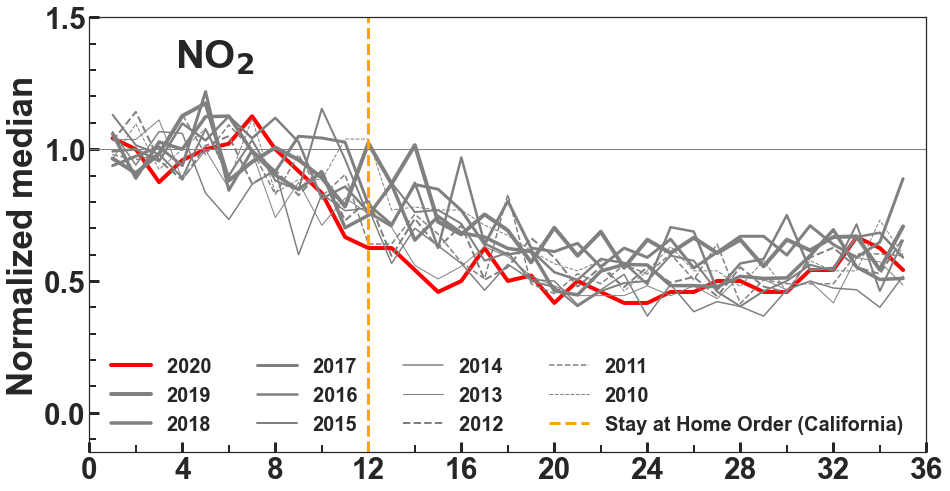

In [15]:
x=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35]
fig= plt.figure(figsize=(15, 8))
plt.style.use('seaborn-white')
ax=fig.add_subplot(111)
plt.plot(x ,qs,color='red', label='2020 ',linewidth=4)
plt.plot(x,qss , color='grey',label='2019', linewidth=4)
plt.plot(x,qsss , color='grey', label='2018',linewidth=3.5)
plt.plot(x,qssss , color='grey', label='2017',linewidth=3)
plt.plot(x ,qq,color='grey', label='2016 ',linewidth=2.5)
plt.plot(x,qqq , color='grey',label='2015', linewidth=2)
plt.plot(x,qqqq , color='grey', label='2014',linewidth=1.5)
plt.plot(x,qqqqq , color='grey', label='2013',linewidth=1)
plt.plot(x ,qz,color='grey', label='2012 ',linewidth=2,linestyle='dashed')
plt.plot(x,qzz , color='grey',label='2011', linewidth=1.5,linestyle='dashed')
plt.plot(x,qzzz , color='grey', label='2010',linewidth=1,linestyle='dashed')


plt.rcParams["axes.labelweight"] = "bold"
ax.yaxis.set_major_locator(MultipleLocator(0.5))
ax.xaxis.set_major_locator(MultipleLocator(4))
plt.ylim(-0.15,1.5)
plt.xlim(0,we+1)
plt.axvline(x=12, color='orange', label='Stay at Home Order (California) ',linestyle='dashed',linewidth=3)
    #plt.axvspan('Week12', 'Week16', alpha=0.1, color='orange',label="Lockdown")
    #plt.xticks(1)
plt.axhline(y=1, color='grey',linewidth=1)
#plt.xticks(np.arange(0, max(x)+1, 2.0))
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
#plt.xlabel('Week',fontsize='35',fontweight='bold')
plt.ylabel('Normalized median',fontsize='35',fontweight='bold')

ax.tick_params(axis='y', which='minor', bottom=True,direction='in',length=7, width=2)
ax.tick_params(axis='y', which='major', bottom=True,direction='in',length=10, width=3)
ax.tick_params(axis='x', which='major', bottom=True,direction='in',length=10, width=3)
ax.tick_params(axis='x', which='minor', bottom=True,direction='in',length=7, width=2)
#plt.ylabel('Median PM2.5 during weeks / Median PM 2.5 in January',fontsize='14', fontweight='bold')
plt.legend(loc='lower right',fontsize='20',frameon=False,ncol=4)
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
                     label.set_fontname('Arial')
                     label.set_fontsize(30)
                     label.set_fontweight('bold')
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.rcParams["font.size"] = "20"
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["axes.labelsize"] = "20"
plt.title('NO$_2$',fontsize='40',fontweight='bold',x=0.15,y=0.87)
plt.savefig('NO2 normalized to Jan.png', bbox_inches='tight')

In [16]:
#Starting IDW
k1=pd.DataFrame(idw5)
k1=k1.drop_duplicates()
k1.columns=['ID','Latitude','Longitude']
k1=k1.reset_index(drop=True)
IDW= list(k1['ID'])

k2=pd.DataFrame(adjusted5)
k2.columns=['ID','Latitude','Longitude','Slope','Week']
k2=k2.drop(['Slope'],axis=1)
k2=k2.drop(['Week'],axis=1)
k2=k2.drop_duplicates()
adjusted5=pd.DataFrame(adjusted5)
adjusted5.columns=['ID','Latitude','Longitude','Slope','Week']
k2.dropna()
k2=k2.drop_duplicates()

In [17]:
#IDW with nearest stations in 50km
from sklearn.neighbors import DistanceMetric
dist = DistanceMetric.get_metric('haversine')
distance=pd.DataFrame(dist.pairwise(k2[['Latitude','Longitude']].to_numpy(), k1[['Latitude','Longitude']].to_numpy())*6373,columns=k1["ID"], index=k2["ID"])

In [18]:
#IDW
Slope1=pd.DataFrame()
w=[]

for i in range (0, len(IDW)):
    
    monitor=IDW[i]
    s=distance[monitor]
    
    #find 3 nearest monitors in 50 km
    nearest=s[s<50]
    nearest=nearest[nearest>0]
    nearest=nearest.sort_values(ascending=True)
    nearest=nearest[:3]
    idw=pd.DataFrame()
    
    #If there are monitors
    if len(nearest)!= 0:
        n=0
        
        o=list(nearest)
        
        #For each of the nearest monitors finding slope and distance:
        for j in range (0,len(nearest)):
            
            nearest_mon=nearest.index[j]
            nearest_slope=list(Slope5[str(nearest_mon)])      
            nearest_slope.append(1/nearest.iloc[j])
            nearest_slope=pd.DataFrame(nearest_slope)
            nearest_slope.columns=[n]
            idw=pd.concat([idw,nearest_slope],axis=1,sort=False)
            n=n+1
            
            length=len(list(idw[0]))
            idw_df=pd.DataFrame()
            df=pd.DataFrame()
            
            #Dataframing slope for nearest monitor and inverse distance to that monitor
            for l in range (0,len(idw.columns)):
                 t=[]      
                 for m in range (0,length-1):

                         t.append([list(idw[l])[m]*list(idw[l])[length-1],list(idw[l])[length-1]])
                       #  print(list(idw[l])[m])
                 t=pd.DataFrame(t)

                 df=pd.concat([df,t],axis=1,sort=False) 
                 df=pd.DataFrame(df)
                 

        idw_df=pd.concat([idw_df,df],axis=1,sort=False)
        idw_df=idw_df.transpose()

        slp=[]
        
        #Aggregating nearest monitor slopes and distance 
        for z in range(0,len(idw_df.columns)):
                row=list(idw_df[z])
                nom=0
                denom=0
                for y in range (0,len(row)-1,2):
                    if pd.notnull(row[y]):
                     nom=nom+row[y]
                     
                     denom=denom+row[y+1]

                if denom!=0:
                 frac=nom/denom
                 slp.append(frac)
        slp=pd.DataFrame(slp)
        slp.columns=[monitor]

        #Output 
        Slope1=pd.concat([Slope1,slp],axis=1,sort=False)
            






In [19]:
#Finding D value from IDW

#Reading file with all the states name
states = pd.read_csv("/Users/Bujin/Downloads/States.csv")

#Reading dates
dateparse = lambda dates: [pd.datetime.strptime(d, '%Y-%m-%d') for d in dates]

#Defining output
DF1=pd.DataFrame()
Slope2=pd.DataFrame()
OT1=pd.DataFrame()
adjusted=[]
idw=[]


#Calling each state file

Data = pd.read_csv("/Users/Bujin/Downloads/NO2.csv",parse_dates=['Date'], date_parser=dateparse)


a=set(Data['ID']).intersection(Slope1.columns) #Taking the intersection of IDW monitors and all monitors
a=list(a)

    #Defining output
df=pd.DataFrame()
slope1=pd.DataFrame()
ot=pd.DataFrame()
    
    #for each station calculate D value   
for iii in range(0,len(a)):
       monitor=Data[Data['ID']==a[iii]]
       
       #Defining as variables
       site=list(monitor['name'])[1]        
       state=list(monitor['State'])[1] 
       idd=list(monitor['ID'])[1]
       county=list(monitor['County'])[1]
       lon=(list(monitor['Longitude'])[1])
       lat=(list(monitor['Latitude'])[1])
       weeknum=0
    
       #Defining output
       List10=[] 
       slope=[]  
    
       #Starting filters
       

       whole=monitor[monitor['Date']<pd.to_datetime('2020-09-'+str(lastday))] ##Change this date (add 7 days each week)
       twentytwenty=pd.concat([whole['Date'],whole['2020']],axis=1,sort=False)
       twentytwenty=twentytwenty.dropna()
       pre=twentytwenty[twentytwenty['Date']<pd.to_datetime('2020-03-19')]
       post=twentytwenty[twentytwenty['Date']>=pd.to_datetime('2020-03-19')]


       #Number of days for adjusting
       adjusting=monitor[monitor['Date']<pd.to_datetime('2020-09-'+str(twoweeks))] ## Change this date (add 7 days each week)

       #dropping years if it has incomplete data
       drop=adjusting.drop(['2020'],axis=1)
       drop=drop.dropna(thresh=0.75*len(adjusting), axis=1)
       
       #checking if it has 2 years out of last 3 years
       Iqr=pd.concat([adjusting['2019'],adjusting['2018'],adjusting['2017']],axis=1,sort=False)
       Iqr = Iqr.dropna(thresh=0.75*len(Iqr), axis=1)
       
       
       
       start='2020-01-01'
       
       #Using monitors that have enough data
       if len(drop.columns)>=10 and len(post)>=length  and len(adjusting)>=totallength and len(pre)>=59 and len(Iqr.columns)>=2:   ##Change this (add 5 days on post and adjusting each week)
                                        
        for j in range(0,len(whole),7): # Week by week
            
           #Start and end date for each week
           start_d = pd.to_datetime(start) + datetime.timedelta(j)
           end_d = start_d + datetime.timedelta(7)
         
           week=monitor[monitor['Date']>=start_d]
           week=week[week['Date']<end_d]
            
           #Week 
           twenty=pd.DataFrame(week["2020"])
           weeknum=weeknum+1 #Week #
           
           #Month (for adjusting)
           end_date = list(week['Date'])[0] + datetime.timedelta(days=21) # +2 weeks
           start_date = list(week['Date'])[0] - datetime.timedelta(days=14) # -2 weeks

        
           # First 2 weeks of the year, add december data from previous year
           if pd.to_datetime('2020-01-01')== list(week['Date'])[0] :
               half=monitor[monitor["Date"]>='2020-12-18']
               month=monitor[monitor["Date"]>='2020-01-01']
               month=month[month['Date']<'2020-01-22']
               half.rename(columns={"2020": "2009", "2019": "2020","2018":"2019","2017":"2018","2016":"2017","2015":"2016","2014":"2015","2013":"2014","2012":"2013","2011":"2012","2010":"2011","2009":'2010'}, inplace=True)
               month = pd.concat((month, half), axis=0)
               month=month.drop(['2009'],axis=1)
           elif list(week['Date'])[0]==pd.to_datetime('2020-01-08'):
               half=monitor[monitor["Date"]>'2020-12-24']
               month=monitor[monitor["Date"]>='2020-01-01']
               month=month[month['Date']<'2020-01-29'] 
               half.rename(columns={"2020": "2009", "2019": "2020","2018":"2019","2017":"2018","2016":"2017","2015":"2016","2014":"2015","2013":"2014","2012":"2013","2011":"2012","2010":"2011",'2009':'2010'}, inplace=True)
               month = pd.concat((month, half), axis=0)
               month=month.drop(['2009'],axis=1)
           else:
               month=monitor[monitor["Date"]>=start_date]
               month=month[month["Date"]<end_date]
               month=month.drop(['2009'],axis=1)
        
           #if len(month.columns)==19:
               #month=month.drop(['2009'],axis=1)
           
           Mnth=month.drop(['2020'], axis=1)
           
           #Change the 2020 data to only that particular week
           month["2020"]=twenty
           
           #Dropping columns to get only historical data
           months=month.drop(['2020'],axis=1)
           months=months.drop(['name'],axis=1)
           months=months.drop(['State'],axis=1)
           months=months.drop(['Longitude'],axis=1)          
           months=months.drop(['Latitude'],axis=1)
           months=months.drop(['Date'],axis=1)
           months=months.drop(['ID'],axis=1)
           months=months.drop(['Site'],axis=1)
           months=months.drop(['County'],axis=1)
           months=months.drop(['id'],axis=1)
           five=months
           five=five.drop(['2010'],axis=1)
           five=five.drop(['2011'],axis=1)
           five=five.drop(['2012'],axis=1)
           five=five.drop(['2013'],axis=1)
           five=five.drop(['2014'],axis=1)           



           #Filtering data, using years that have enough data
           historical=months.dropna(thresh=0.75*len(months),axis=1)
           #historical=months.dropna(axis=1,how='all')
           histfive=five.dropna(thresh=0.75*len(five),axis=1)
           #Finding median for each year
           medians=np.nanmedian(historical,axis=0)
           fivemed=np.nanmedian(histfive,axis=0)
           #Finding iqr
           IQR_melt = pd.melt(month.reset_index(), id_vars=['index'], value_vars=Iqr.columns)
           IQR_melt=IQR_melt.dropna()
           IQR_melt.columns = ['index', 'year', 'value']
           
           #Finding slope of historical data
           hist_slope=pd.DataFrame({"x":pd.to_numeric(historical.columns),"y":np.array(medians)})
           x=hist_slope["x"]
           y=hist_slope["y"]
           five_slope=pd.DataFrame({"x":pd.to_numeric(histfive.columns),"y":np.array(fivemed)})
           x5=five_slope["x"]
           y5=five_slope["y"]


           #Finding historical median
           
           Historical_melt = pd.melt(month.reset_index(), id_vars=['index'], value_vars=historical.columns)
           Historical_melt.columns = ['index', 'year', 'value']
 
           five_melt = pd.melt(month.reset_index(), id_vars=['index'], value_vars=histfive.columns)
           five_melt.columns = ['index', 'year', 'value']


                  
                  #10 year median 
           Med=np.nanmedian(five_melt['value'])  
                  
                  #Adjusting historical median with IDW slope
           adjusted_med =  list(Slope1[idd])[weeknum-1] * (len(histfive.columns)+1)/2 + Med

                  #Calculating D value 
           D_value=(np.nanmedian(month['2020'])-adjusted_med)/iqr(IQR_melt['value'])  
                
                  #Appending for output
           List10.append([D_value,np.nanmedian(month['2020']),Med,adjusted_med,list(Slope1[idd])[weeknum-1],999,("Week "+str(weeknum)),state,idd,county,lat,lon])
           slope.append(list(Slope1[idd])[weeknum-1])       

                
        slope=pd.DataFrame(slope)
        
        #Preparing for idw
        
        if slope.size>0:
           slope.columns=[str(idd)]
         

        ot=pd.concat([ot,monitor],axis=0,sort=False)
        slope1=pd.concat([slope1,slope],axis=1,sort=False)   
        List10=pd.DataFrame(List10)
        df=pd.concat([df, List10], axis=0, sort=False)      

    #Concating for output
       
OT2=pd.concat([OT1,ot],axis=0,sort=False)
DF1=pd.concat([DF1, df], axis=0, sort=False)
Slope2=pd.concat([Slope2,slope1],axis=1,sort=False)
  

/Users/Bujin/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning:

Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.

/Users/Bujin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.

/Users/Bujin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/Bujin/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning:

All-NaN slice encountered



In [20]:
#Concat both outputs
MapData=pd.concat([DF5,DF1],axis=0,sort=False)
MapData.columns=['Ratio','Median','Unadjusted','Expected','Slope','Rsquared','Week','state','ID','County','Latitude','Longitude']

In [21]:
Map=MapData.dropna()
ag = Map.groupby('ID')['Week'].nunique()
Dta=pd.DataFrame()

for i in range (0,len(ag.index)):
    a=ag.index[i]
    indexNames = MapData[ MapData['ID'] == a ].index
    #using station that have at least 75% of the weeks
    if ag.iloc[i]>28:
      Dta=pd.concat([Dta,MapData[MapData['ID']==a]])
Dta=Dta.dropna()
Dta.drop_duplicates(subset=['Week', 'ID'], inplace=True, keep='first')
Dta.to_csv(r"/Users/Bujin/Downloads/ NO2 5 year non aggregated.csv", index = False)



In [22]:
Dta['ID'].nunique()

127